### Imports

In [1]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt
import yfinance as yf

### Structure Data 

In [2]:
# data extraction 
start_date="2017-01-01"
end_date="2022-06-01"
symbol="SPY"


data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close"]]

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  1361


,Open,High,Low,Adj Close,Returns,Range
Date,,,,,,
2017-01-04,225.619995,226.750000,225.610001,201.823288,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,201.662933,-0.000795,0.004879
2017-01-06,226.529999,227.750000,225.899994,202.384415,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,201.716385,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,201.716385,0.000000,0.006371


In [4]:
# Add Moving Average
df["MA_12"] = df["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()


In [5]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  861
X_train From:  2017-01-04 00:00:00
X_train To:  2018-12-28 00:00:00
X_test From:  2018-12-31 00:00:00
X_test To:  2022-05-31 00:00:00


### Train HMM

In [6]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [7]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,
2018-12-31,249.559998,231.251648,0.008759,0.010991,230.767398,238.151924,1
2019-01-02,245.979996,231.492249,0.001040,0.021387,229.714916,237.173341,2
2019-01-03,248.229996,225.968155,-0.023863,0.020109,228.577735,235.858547,3
2019-01-04,247.589996,233.537170,0.033496,0.024032,228.463042,234.744287,3
2019-01-07,252.690002,235.378525,0.007885,0.016926,228.523259,234.114158,2


### Run Backtest

In [8]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0
df_main[:15]


,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM,MA_Signal
Date,,,,,,,,
2018-12-31,249.559998,231.251648,0.008759,0.010991,230.767398,238.151924,1,0.0
2019-01-02,245.979996,231.492249,0.001040,0.021387,229.714916,237.173341,2,0.0
2019-01-03,248.229996,225.968155,-0.023863,0.020109,228.577735,235.858547,3,0.0
2019-01-04,247.589996,233.537170,0.033496,0.024032,228.463042,234.744287,3,0.0
2019-01-07,252.690002,235.378525,0.007885,0.016926,228.523259,234.114158,2,0.0
2019-01-08,256.820007,237.589981,0.009395,0.013031,229.060613,233.607294,1,0.0
2019-01-09,257.559998,238.700317,0.004673,0.010617,230.004035,233.427969,1,0.0
2019-01-10,256.260010,239.542389,0.003528,0.014325,231.405869,233.266840,1,0.0
2019-01-11,257.679993,239.634918,0.000386,0.007703,233.305829,233.107489,1,1.0


In [9]:
# Add HMM Signals
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values


In [10]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [11]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [12]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [13]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,
2022-05-23,392.829987,387.495941,0.018710,0.018828,388.199643,397.341713,3,0.0,0,0.0,0.018537,0.516199,0.675646,-0.0,0.294888,0.342975
2022-05-24,392.559998,384.537903,-0.007634,0.021165,386.780006,395.732284,3,0.0,0,0.0,-0.007663,0.508536,0.662855,-0.0,0.294888,0.342975
2022-05-25,392.309998,387.935242,0.008835,0.019291,386.714923,394.861555,2,0.0,0,0.0,0.008796,0.517332,0.677546,0.0,0.294888,0.342975
2022-05-26,398.670013,395.686737,0.019981,0.021559,387.220950,394.305555,3,0.0,0,0.0,0.019784,0.537116,0.711066,0.0,0.294888,0.342975
2022-05-27,407.910004,405.400452,0.024549,0.018837,389.052244,393.722124,3,0.0,0,0.0,0.024253,0.561369,0.753071,0.0,0.294888,0.342975


### Calculate Metrics

In [14]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [15]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)


In [16]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 75.3%
Returns Strategy: 34.3%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.7
Sharpe Strategy: 0.93


# plot results

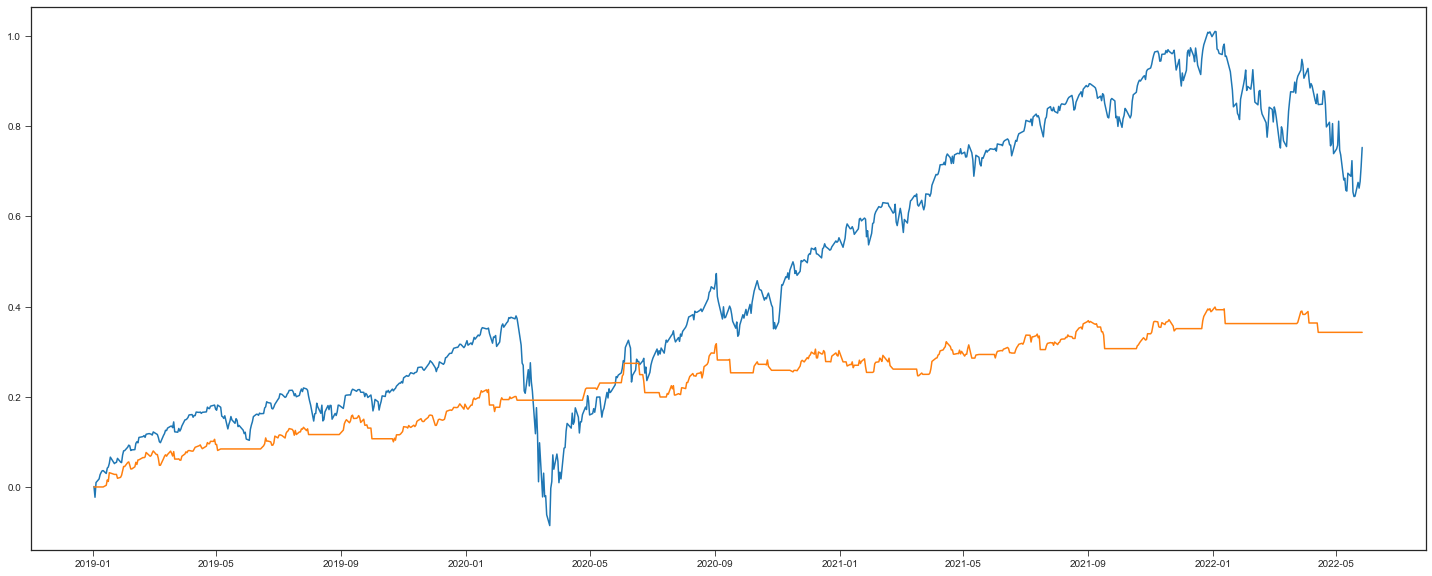

In [17]:
# Plot Equity Curves
fig = plt.figure(figsize = (25, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()

### Save data

In [18]:
# Save data
df_main.to_csv("data/HMM-SPY.csv")